# EEMD + ARIMA

---

In [18]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date
from datetime import timedelta
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

# Save the log
import os
import pickle
# Lasso
from sklearn.linear_model import Lasso

import time
# EEMD
from PyEMD import EEMD

# ARIMA
from pmdarima.arima import auto_arima

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [19]:
# Minus
matplotlib.rcParams['axes.unicode_minus'] = False
# 한글
plt.rcParams['font.family'] = 'Malgun Gothic'

## Data Explore

In [20]:
df = pd.read_csv("../Data/All_capstone_df.csv")
df['Date'] = pd.to_datetime(df['Date'])

---

In [21]:
def lasso_feature_selection(df):
    tmp_df = df.drop(columns=['Date'])
    # 데이터프레임에서 y값 열 추출
    y = tmp_df.loc[:, 'y']
    
    # 데이터프레임에서 y값 열을 제외한 나머지 열을 X로 설정
    X = tmp_df.drop(columns='y')
    
    # Lasso 회귀 모델 생성
    lasso = Lasso(alpha=10)  # alpha 값을 조절하여 정규화 강도 조절 가능
    
    # 모델 훈련
    lasso.fit(X, y)
    
    # 각 변수의 계수 출력
    coefficients = pd.Series(lasso.coef_, index=X.columns)
    print("각 변수의 계수:")
    print(coefficients)
    
    # 선택된 변수만 보여주기
    selected_var = coefficients[coefficients != 0]
    print("\n선택된 변수:")
    print(selected_var)
    
    return selected_var.index.tolist()

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train: ~ 2012-06-30
    
    - test :  2022-07-01 ~ 2012-12-31

In [22]:
# train과 test로 데이터 split
def split_data(eIMF_df):
    
    train_df = eIMF_df[eIMF_df['Date']<'2022-07-01'].reset_index(drop=True)
    test_df = eIMF_df[eIMF_df['Date']>='2022-07-01'].reset_index(drop=True)
    return train_df, test_df

---

## EEMD
    * 시계열 그래프를 ensembled IMF (앙상블 내재모드 함수)로 분해
    * n 개의 eIMFs와  1개의 Residual 생성

In [23]:
def eemd_fit(df):
    # Define signal
    t = np.array(df['Date']) # x-axis
    s = np.array(df['y']) # y-axis

    # EEMD 객체 생성
    eemd = EEMD() # trials: EMD 횟수(default:100)
    
#     # 극값을 감지하는 방법으로 parabolic 방법을 선택
#     emd = eemd.EMD
#     emd.extrema_detection="parabol"
    
    # eIMFs로 분해
    eIMFs = eemd.eemd(s, t, max_imf=1) # max_imf: IMF 제한 개수(-1: 없음)
    nIMFs = eIMFs.shape[0] # eIMF의 개수
    
    # 분해된 eIMFs와 잔차를 변수에 할당
    imfs, residue = eemd.get_imfs_and_residue()
    
    # 앙상블 IMFs 들의 DataFrame 생성
    all_eIMFs_df = pd.DataFrame(eIMFs).transpose() 
    all_eIMFs_df[nIMFs] = residue # residue 열 마지막 열로 추가
    all_eIMFs_df.insert(0, 'Date', df['Date']) # Date 열 추가
    
    # IMF & Residue 시각화
    plt.figure(figsize=(12, nIMFs*2)) # Figure size 설정
    for i in range(nIMFs):
        plt.subplot(nIMFs+1, 1, i+1) # i번째 subplot
        plt.plot(df['Date'], all_eIMFs_df[i], 'g')
        plt.title('IMF '+str(i+1), fontsize=10)

    # Residue plot
    plt.subplot(nIMFs+1, 1, nIMFs+1)
    plt.plot(df['Date'], all_eIMFs_df[nIMFs], 'r')
    plt.title('Residue', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return all_eIMFs_df, nIMFs # eIMF+Residue들로 이루어진 df, eIMF의 개수

### eIMFs 데이터프레임 추출

In [24]:
# eIMF들을 추출하여, Date와 y로 이루어진 데이터프레임 추출하고 딕셔너리에 저장
def extract_eIMFs(product_df, all_eIMFs_df, nIMFs):
    all_eIMFs_dict = {}
    # eIMF개수+Residue(1) 만큼 반복
    for i in range(nIMFs+1):
        tmp_df = all_eIMFs_df[['Date', i]] # n번째 eIMF에 해당하는 날짜와 값 추출
        tmp_df.columns=['Date', 'y'] # i -> y 로 열이름 변경
        
        tmp_df = pd.merge(tmp_df, product_df.drop(columns=['Product', 'y', '년월']), on='Date')
        all_eIMFs_dict[f'eIMFs_{i}'] = tmp_df # n번째 eIMF 정보(마지막은 Residue) 딕셔너리에 저장
                           # df: Date, y 2열로 이루어진 dataFrame
    return all_eIMFs_dict # {eIMFs_1: df1, eIMFs_2: df2, ...} 

### ARIMA combined EEMD 


In [25]:
'''
eIMFs의 DataFrame을 하나씩 반복하면서,
auto_arima로 (p,d,q)의 최적값을 찾고,
각 eIMFs들을 예측하고 예측 DataFrame을 Return
'''
def EEMD_ARIMA(all_eIMFs_dict):
    model_dict = {}
    pred_dict = {}
    
    for i in all_eIMFs_dict.keys():
        print(f'--------Total: 0~{len(all_eIMFs_dict)-1} eIMFs, Now: {i} --------')
        # eIMF_df 불러오기
        eIMF_df = all_eIMFs_dict[i]
        
        selected_features = lasso_feature_selection(eIMF_df)
        print(selected_features)
        # Data split
        train_df, test_df = split_data(eIMF_df)
        # 저장할 값
        predictions = []
        # Search the proper (p,d,q)
        best_model = auto_arima(train_df['y'], X=train_df[selected_features],
                            start_p=1, start_q=1,
                            max_p=5, max_q=5, 
                            max_d=2, trace=True,
                            suppress_warnings=True)
        
        for test_date in test_df['Date']:
            test_date_prev_1 = test_date - pd.Timedelta(days=1)
            train_until_test_df = eIMF_df[eIMF_df['Date'] < test_date]
      
            best_model_fit = best_model.fit(train_until_test_df['y'], X=train_until_test_df[selected_features])
        
            # Predict the next day's value and add it to the predictions list
            exog_for_pred = train_until_test_df[train_until_test_df['Date'] == test_date_prev_1][selected_features].values.reshape(1, -1)
            prediction = best_model_fit.predict(n_periods=1, X=exog_for_pred).iloc[0]
            predictions.append(prediction)  # replace negative predictions with 0

        # Make the Result DataFrame
        res_df = test_df.copy()
        res_df['Pred'] = predictions
        res_df.set_index('Date', inplace=True)
        # res_df: ['y'','Pred'] index='Date'
        # dictionary에 result_df 저장
        pred_dict[i] = res_df
        
    return model_dict, pred_dict

## Save and Load the model 

In [26]:
def save_model(product_code, model_dict):
    today = date.today()
    folder_path = 'Result/EEMD+ARIMA_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict, f)
    return model_dict

In [27]:
# 학습된 모델 pickle파일에서 불러오기
def load_model(file_name):
    file_path = f'Result/EEMD+ARIMA_Result/Model/{file_name}'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return model_dict

## Total Result

    - 각각의 eIMFs들의 예측값을 합하여 전체의 예측값을 도출하였음.
    - 전체 예측값이 음수가 나온 경우 0으로 대치함.
    - EEMD의 수식은 아래에 근거하였음.
    
        IMFs(t)=ΣIMFs j(t)
        
    
 

In [28]:
def make_all_result_df(pred_dict):
    all_df = pd.DataFrame()
    for tmp_df in pred_dict.values():
        all_df = pd.concat([all_df, tmp_df], axis=1)
    pred_df = all_df['Pred'].sum(axis=1) # eIMFs 예측값을 모두 더함
    actual_df = all_df['y'].sum(axis=1)
    # 전체 결과 데이터프레임 생성
    all_result_df = pd.DataFrame({'Pred': pred_df, 'y': actual_df})
    all_result_df.loc[all_result_df['Pred']<0, 'Pred']=0 # 음수 예측 값은 0으로 대치

    # all_res_df: ['y'','Pred'] index='Date'
    return all_result_df

## Plot the result

In [29]:
"""
Plot the actual vs predition and save the figure in the given directory
"""
def actual_pred_plot(product_code, pred_dict, all_result_df, metric_df):
    today = date.today()
    # 전체 결과 비교를 위해 dictionary에 추가
    pred_dict['all_result'] = all_result_df
    
    save_path = os.path.join("Result", "EEMD+ARIMA_Result", product_code+f'_{today.month:02d}{today.day:02d}')

    # 결과 df 하나씩 불러오기
    for i, res_df in enumerate(pred_dict.values()):
        img_n = len(pred_dict)
        title = f"Pred Actual Plot - ({i+1}/{len(pred_dict)-2})'s eIMF"
        if i == img_n-2: title = "Residue"
        actual = res_df['y']
        pred = res_df['Pred']
        save_name = f'{product_code}_eIMF_{i+1}'
        
        # All result -> 마지막 image
        if i == img_n-1: 
            title = f"{product_code}-All Result"
            save_name = f'{product_code}_all_result'

        plt.figure(figsize=(16, 8))
        plt.title(title, fontsize=20)
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Order Demand", fontsize=14)
        plt.plot(actual, label ='Actual', color='r', marker='o', ms=3)
        plt.plot(pred, label='Prediction', color='b', marker='o', ms=3)
        plt.legend(loc="upper right")
        
        # Plot 결과 저장
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save the figure
        today_date = f'_{today.month:02d}{today.day:02d}'
        plt.savefig(os.path.join(save_path, save_name+'.png'))
        plt.show()
        
    # metric도 각 path에 
    metric_df.to_csv(os.path.join(save_path, f'{product_code}_Metric.csv'), encoding="utf-8-sig")
    
    del pred_dict['all_result']
    plt.close('all') # close all figures to free up memory

## Metrics

In [30]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [31]:
def calculate_metrics(pred_df):
    # 계산된 메트릭을 저장하기 위해 데이터프레임 초기화
    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])
    
    actual = pred_df['y']
    pred = pred_df['Pred']

    # 메트릭 계산
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)

    # 계산된 메트릭을 데이터프레임에 추가
    tmp_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2': [round(R2, 4)]})

    # 메트릭 데이터프레임에 결과 추가
    metric_df = pd.concat([metric_df, tmp_df])
    return metric_df

---

## Check the Result

In [32]:
def make_metric_df(product_code, pred_dict, all_result_df):
    today = date.today()

    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])
    # eIMF 반복하면서 Metric 평가
    for i, pred_df in pred_dict.items():
        imf_df = calculate_metrics(pred_df)
        metric_df = pd.concat([metric_df, imf_df])
    
    imf_idx = pd.Index(['eIMF_'+str(i+1) for i in range(len(pred_dict))]) # changed result_dict to pred_dict
    metric_df.index = imf_idx # Assign the created index to metric_df
    metric_df = pd.concat([metric_df, calculate_metrics(all_result_df)], axis=0)
    metric_df = metric_df.rename(index={metric_df.index[-1]: 'All'}) # 마지막 행은 Total 결과
    
    return metric_df

In [33]:
def execute_EEMD_ARIMA(product_code):
    start_time = time.time()

    product_code = product_code # 예측하고자 하는 코드 입력
    product_df = df[df['Product']== product_code].reset_index(drop=True)
    
    # EEMD 수행
    all_eIMFs_df, nIMFs = eemd_fit(product_df)
    
    # EEMD 결과에서 각 eIMFs' DF 추출
    all_eIMFs_dict = extract_eIMFs(product_df, all_eIMFs_df, nIMFs)
    
    # EEMD+ARIMA 실행
    model_dict, pred_dict = EEMD_ARIMA(all_eIMFs_dict) #dictionary, time_steps, epochs
    all_result_df = make_all_result_df(pred_dict)
    # 모델 저장
    save_model(product_code, model_dict)
    metric_df = make_metric_df(product_code, pred_dict, all_result_df)

    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df)
    
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력

========== 2210 ==========


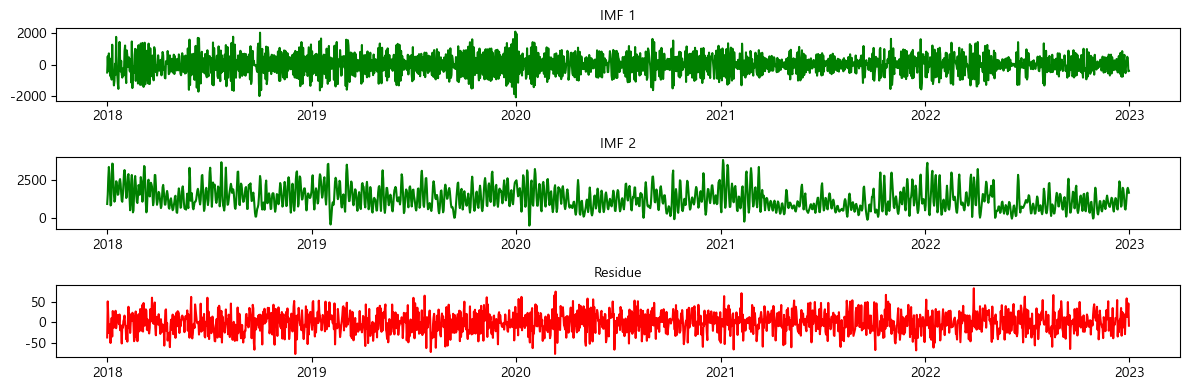

--------Total: 0~2 eIMFs, Now: eIMFs_0 --------
각 변수의 계수:
월                         1.009908
일                        -4.204360
요일                     -119.474903
공휴일여부                  -246.532830
소비자물가지수(2020＝100)_전국     -0.000000
기업경기실사지수(실적)_제 조 업        1.920116
기업경기실사지수(전망)_제 조 업       -2.303842
경제심리지수_경제심리지수(순환변동치)      0.000000
경제심리지수_경제심리지수(원계열)       -0.000000
설비투자지수_총지수               -0.294829
수입물가지수(기본분류)_총지수         -0.028152
수출물가지수(기본분류)_총지수          0.000000
평균기온(°C)                  0.737355
일강수량(mm)                 -1.414855
평균 풍속(m/s)                0.524680
dtype: float64

선택된 변수:
월                       1.009908
일                      -4.204360
요일                   -119.474903
공휴일여부                -246.532830
기업경기실사지수(실적)_제 조 업      1.920116
기업경기실사지수(전망)_제 조 업     -2.303842
설비투자지수_총지수             -0.294829
수입물가지수(기본분류)_총지수       -0.028152
평균기온(°C)                0.737355
일강수량(mm)               -1.414855
평균 풍속(m/s)              0.524680
dtype: float64
['월', '일', '요일'

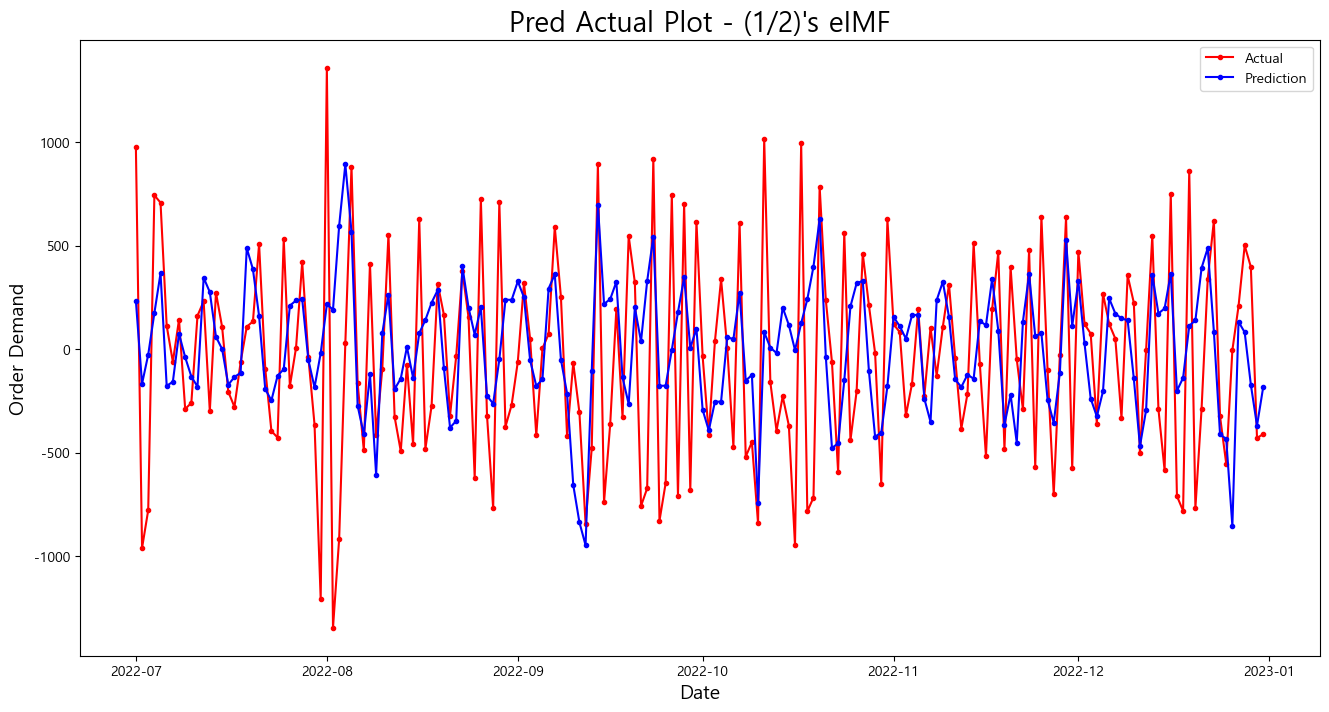

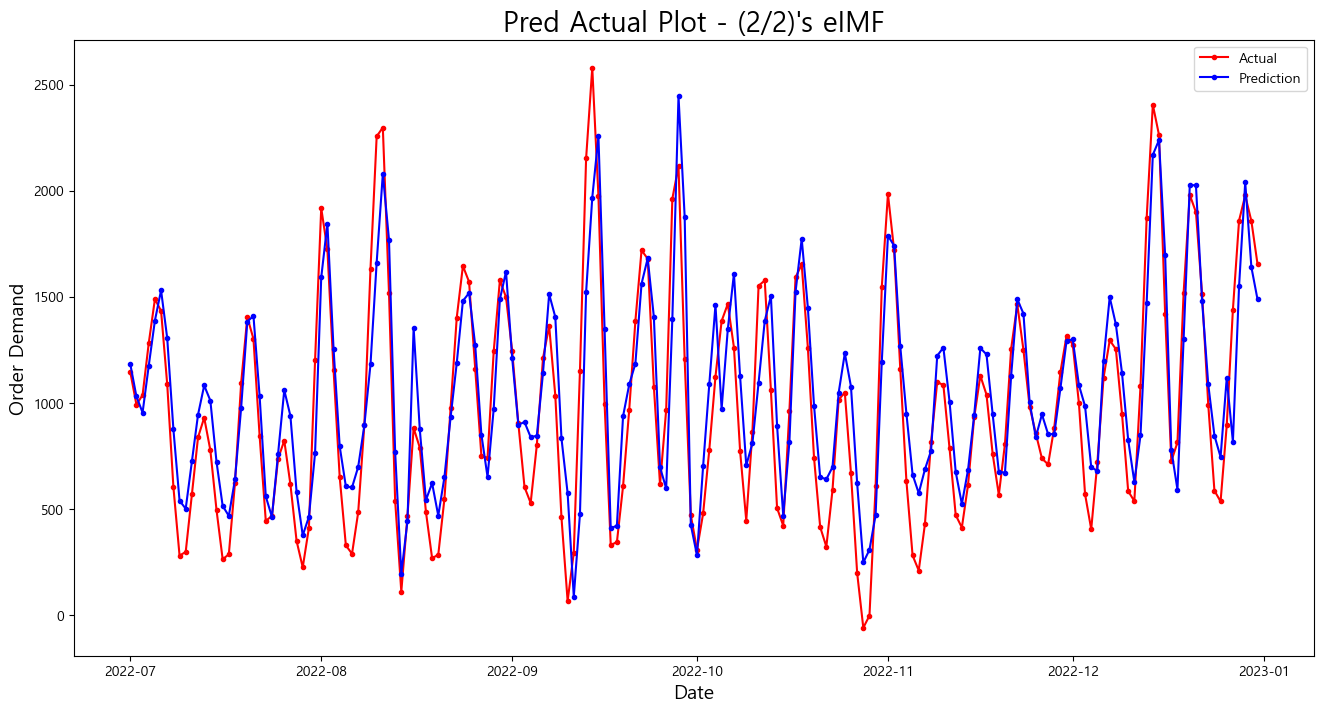

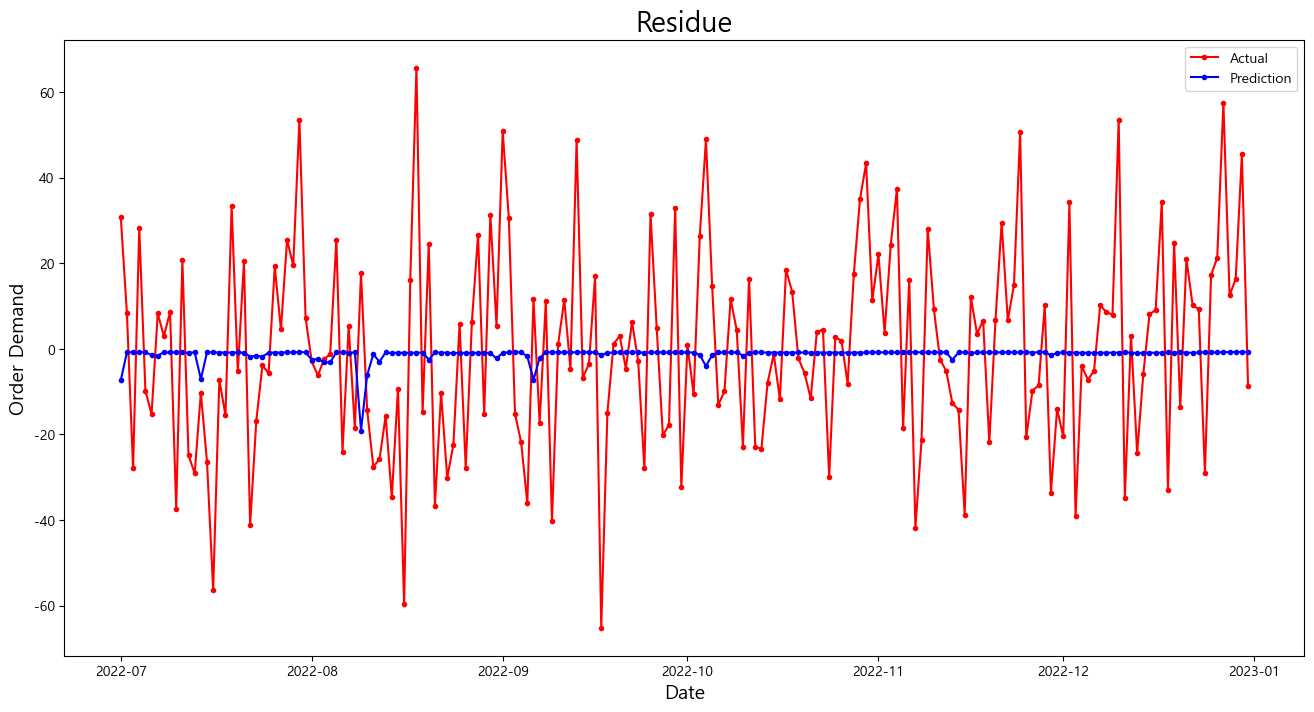

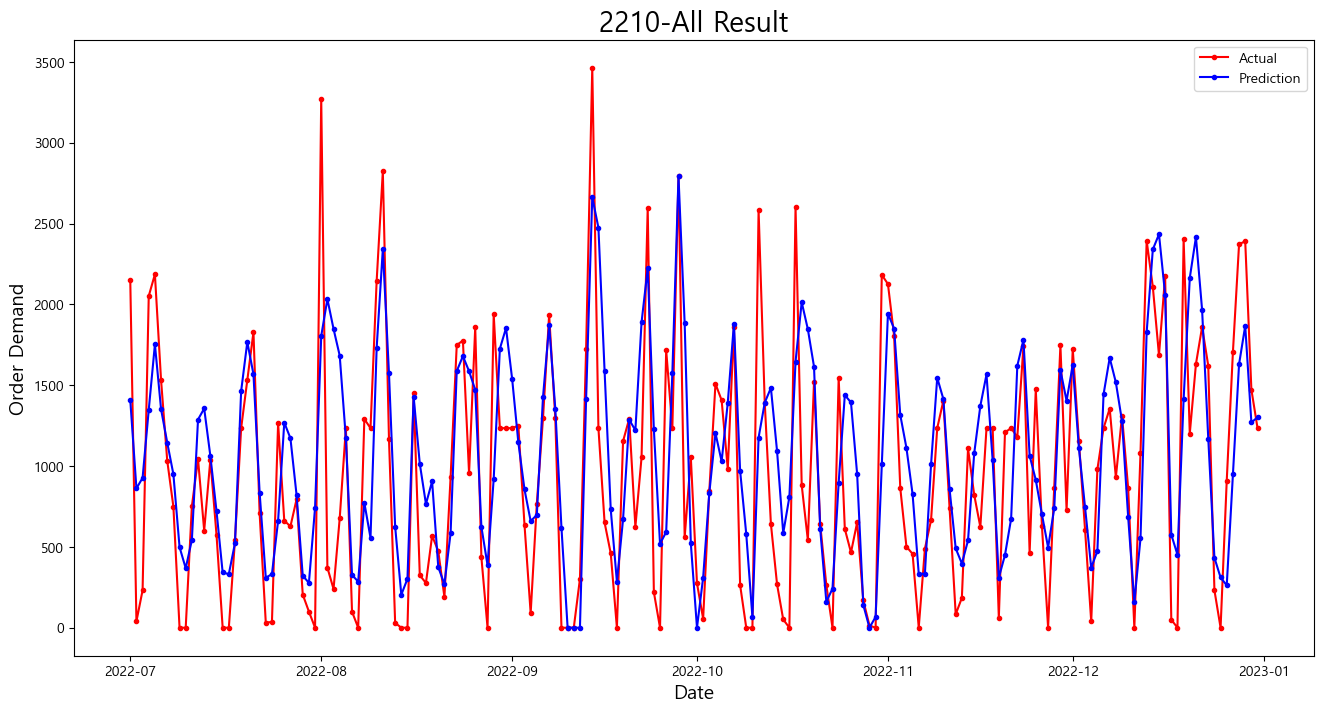

실행 시간: 25.85 분


In [34]:
for code in df['Product'].unique()[:1]:
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    execute_EEMD_ARIMA(code)